In [2]:
import pandas as pd
from io import StringIO # 在内存中读写str，识别换行符号，也可以用转义字符'\n'代替
csv_data = '''A,B,C,D
1.0,2.0,3.0,4.0
5.0,6.0,,8.0
0.0,11.0,12.0,''' # Python2.7 需要将csv_data转成unicode： e.g. csv_data = unicode(csv_data)

df = pd.read_csv(StringIO(csv_data))
df

,A,B,C,D
0,1.0,2.0,3.0,4.0
1,5.0,6.0,NaN,8.0
2,0.0,11.0,12.0,NaN


In [4]:
df.isnull().sum()

A    0
B    0
C    1
D    1
dtype: int64

In [13]:
df.isnull().sum(axis=1)

0    0
1    1
2    1
dtype: int64

In [5]:
# scikit-learn中是用NumPy arrays进行数据处理的，但在数据预处理阶段，pandas 中的DataFrame用做预处理更方便，可以通过values属性将
# DataFrame转换成 NumPy arrays
df.values

array([[ 1.,  2.,  3.,  4.],
       [ 5.,  6., nan,  8.],
       [ 0., 11., 12., nan]])

In [6]:
df.dropna() # dropna()默认按行移除，也就是移除有缺失值的样本

,A,B,C,D
0,1.0,2.0,3.0,4.0


In [7]:
df.dropna(axis = 1) #按列移除

,A,B
0,1.0,2.0
1,5.0,6.0
2,0.0,11.0


In [8]:
df.dropna(how='all') #只移除所有的列都为nan的行，也就是移除特征（列）全部为空值的样本（行）

,A,B,C,D
0,1.0,2.0,3.0,4.0
1,5.0,6.0,NaN,8.0
2,0.0,11.0,12.0,NaN


In [9]:
df.dropna(thresh=4) # 移除每行中有没有四个或者四个以上非空值的行，也就是移除特征中没有四个或者四个以上非空值的样本

,A,B,C,D
0,1.0,2.0,3.0,4.0


In [11]:
df.dropna(subset=['C']) # 只移除在特定的列中的值为空值的行

,A,B,C,D
0,1.0,2.0,3.0,4.0
2,0.0,11.0,12.0,NaN


In [16]:
'''
数据缺失值处理，单纯的移除数据可能会造成最后样本数量过少，导致分析没有可能性
或者移除了过多的特征列，导致缺失过多的有价值的信息
以下介绍怎么样处理缺失值：插值方法（interpolation techniques)
'''
# 最常见的插值方法是mean imputation（也叫mean substitution）
'''
实际上，这个方法不推荐使用，在大部分情况下，没有其他方法的时候可以采取这个方法。
原因：1： mean imputation没有保持变量之间的关系（因为是观察值的均值，如果说缺失数据是随机缺失的，那么这个均值估计才是无偏的，也是这个方法实现的逻辑。
如果说只是估计均值（点估计），那么这个估计是无偏的，但是会让标准差有偏。但是大部分的研究是对变量之间的关系感兴趣，所以mean imputation不是一个好的选择。
当y值缺失的时候，用mean imputation一般会降低x，y之间的相关性，但是如果是x缺失，用这种方法，会增加x，y之间的相关性）
2. single imputation（也就是单一值替换）会低估误差的方差（error variation），因为这些替换值都是估计的，会存在误差，但是统计软件认为这些
值是真实的，所以会降低标准差的估计，会导致p-value的降低，增加Type I误差的几率。
建议方法： multiple imputation 和 maximum likelihood

处理缺失数据的三个标准：
1、非偏置的参数估计（unbiased parameter estimates): 不管你估计means, regressions或者是odds ratios，都希望参数估计可以准确代表真实的总体参数。
在统计项中，这意味着估计需要是无偏的。有缺失值可能会影响无偏估计，所以需要处理。
2、有效的能力（adequate power)：删除缺失数据会降低采样的大小，因此会降低power。如果说问题是无偏的，那么得到的结果会是显著的，那么会有足够的能力来检验这个效力。
（have adequate power to detect your effects)。反之，整个检测可能失效。
3、准确的标准差（accurate standard errors）（影响p值和置信区间）：不仅需要参数估计无偏，还需要标准差估计准确，在统计推断中才会有效。
这也是为什么mean imputation的填充方法不好的原因。

两个推荐的关于缺失值的处理方法：multiple imptation 和 maximum likelihood
这两个方法满足前面处理缺失数据的三个标准。
方法的假设前提：这两个方法要求数据是随机缺失的————与缺失值无关。
满足这个假设，那么这个估计（也就是说模型的参数（e.g.回归系数）和标准差）是无偏的，并且不会缺少估计能力（no loss of power)。

multiple imputation(MI):
类似与以前的imputation方法，MI对缺失的数据补充估计值。但是为了捕捉这些估计值的不确定性，MI多次估计这个值。因为在imputation方法中有
内嵌的误差，所以多次估计的值会相似，但不会一致。
这个结果是多个数据集合，所有没有缺失的值有相同的值，并且每个数据集的imputed values的值都是有一点点区别的。（The result is multiple data sets
with identical values for alll of the non-missing values and slightly different valus for the imputed values in each data set.)
针对这些不同的数据集，都用已经选定好的模型进行拟合，合并这些模型的结果。因为这imputed values 里面有方差，所以在参数估计中也会存在方差，这样
就可以准确的估计标准差和p值）

maximum likelihood:
第二种方法是利用最大似然估计分析所有的，非完全的数据集。这个方法不会impute任何数据，但是会利用每一个样本中可提供的数据来计算最大似然估计。
采用最大似然估计的参数是在观察数据中最有可能的参数的值。
当数据丢失的时候，我们可以条件化似然函数（factor the likelihood function)。这个似然是分开某些变量有完整数据和和全部的变量有完整数据的数据分开计算的。
这两个似然函数同时最大化来找到估计值。与multiple imputation类似，这个方法给出无偏参数估计和标准差。这个方法的优点是没有multiple imputation要求的那样
需要仔细的选择需要impute values。但是这种方法仅限于线性模型。

一般在处理缺失值中，可以采用回归的方法或者是knn的方法拟合缺失值。
'''

from sklearn.preprocessing import Imputer
imr = Imputer(missing_values='NaN', strategy='mean',axis=0) # median, most frequency（可供选择的方法）
imr = imr.fit(df)
imputed_data = imr.transform(df.values)
imputed_data

array([[ 1. ,  2. ,  3. ,  4. ],
       [ 5. ,  6. ,  7.5,  8. ],
       [ 0. , 11. , 12. ,  6. ]])

In [18]:
from sklearn.linear_model import LogisticRegression
help(LogisticRegression)

Help on class LogisticRegression in module sklearn.linear_model.logistic:

class LogisticRegression(sklearn.base.BaseEstimator, sklearn.linear_model.base.LinearClassifierMixin, sklearn.linear_model.base.SparseCoefMixin)
 |  Logistic Regression (aka logit, MaxEnt) classifier.
 |  
 |  In the multiclass case, the training algorithm uses the one-vs-rest (OvR)
 |  scheme if the 'multi_class' option is set to 'ovr', and uses the cross-
 |  entropy loss if the 'multi_class' option is set to 'multinomial'.
 |  (Currently the 'multinomial' option is supported only by the 'lbfgs',
 |  'sag' and 'newton-cg' solvers.)
 |  
 |  This class implements regularized logistic regression using the
 |  'liblinear' library, 'newton-cg', 'sag' and 'lbfgs' solvers. It can handle
 |  both dense and sparse input. Use C-ordered arrays or CSR matrices
 |  containing 64-bit floats for optimal performance; any other input format
 |  will be converted (and copied).
 |  
 |  The 'newton-cg', 'sag', and 'lbfgs' solve

feature selection  
greedy algorithm  
这里介绍序列向后选择法（这属于绕封法做feature selection的一种（wrapper））  
用贪婪算法一般选择的是局部最优值，但是由于一般寻找全局最有在实际情况当中无法做到，但是贪婪算法能够得到复杂度稍低并且更加有效的解答。
这里做将d-dimension数据中选取k-dimension数据的实现  
1、初始化k=d,d是输入样本空间的特征维度大小  
2、定义好评价方程J（criterion function）选择在$x \in X_{k}$中能够最大化评价标准的特征$x^{-} = argmax J(X_{k}-x)$  
3、缉拿个特征$x^{-}$从特征集合当中移除，$X_{k-1} = X_{k}-x^{-}, k = k-1$  
4、当k等于我们想要的特征的数目的时候，终止，如果不是，重回步骤2.  

In [3]:
df_wine = pd.read_csv('http://archive.ics.uci.edu/ml/machine-learning-databases/wine/wine.data',header=None)
df_wine.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13
0,1,14.23,1.71,2.43,15.6,127,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065
1,1,13.20,1.78,2.14,11.2,100,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050
2,1,13.16,2.36,2.67,18.6,101,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185
3,1,14.37,1.95,2.50,16.8,113,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480
4,1,13.24,2.59,2.87,21.0,118,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735


In [4]:
from sklearn.cross_validation import train_test_split
X,y = df_wine.iloc[:,1:].values, df_wine.iloc[:,0].values
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size = 0.3,random_state=0)

/home/lily/tf3.6/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [5]:
from sklearn.preprocessing import StandardScaler
stdsc = StandardScaler()
X_train_std = stdsc.fit_transform(X_train)
X_test_std = stdsc.transform(X_test)

In [16]:
from sklearn.base import clone
from itertools import combinations
import numpy as np
from sklearn.cross_validation import train_test_split
from sklearn.metrics import accuracy_score

class SBS():
    #from sklearn.base import clone
    def __init__(self,estimator,k_features,scoring = accuracy_score,test_size=0.25,random_state=1):
        self.scoring = scoring
        self.estimator = clone(estimator)
        self.k_features = k_features
        self.test_size = test_size
        self.random_state = random_state
        
    def fit(self, X, y):
        X_train, X_test, y_train, y_test = \
        train_test_split(X,y,test_size=self.test_size,random_state=self.random_state)
        
        dim = X_train.shape[1]
        self.indices_ = tuple(range(dim)) #(0,1,2,...,dim-1)
        self.subsets_ = [self.indices_]
        score = self._calc_score(X_train,y_train,X_test,y_test,self.indices_)
        self.scores_ = [score]
        
        while(dim) > self.k_features:
            scores = []
            subsets = []
            
            for p in combinations(self.indices_, r=dim-1): # 从现在存在的特征维度（dim）中，组合（dim-1)维数据，分别计算他们的拟合评分
                score = self._calc_score(X_train,y_train,X_test,y_test,p)
                scores.append(score)
                subsets.append(p)
                
            best = np.argmax(scores)
            self.indices_ = subsets[best]
            self.subsets_.append(self.indices_)
            dim -= 1
            
            self.scores_.append(scores[best])
            
        self.k_score_ = self.scores_[-1]
        return self
    
    def transform(self,X):
        return X[:,self.indices_]
    
    def _calc_score(self, X_train, y_train, X_test, y_test, indices):
        self.estimator.fit(X_train[:,indices],y_train)
        y_pred = self.estimator.predict(X_test[:,indices])
        score = self.scoring(y_test,y_pred)
        return score
    
    

In [15]:
from sklearn.neighbors import KNeighborsClassifier
import matplotlib.pyplot as plt
knn = KNeighborsClassifier(n_neighbors=2)
sbs = SBS(estimator = knn,k_features = 1)
sbs.fit(X_train_std,y_train)
k_feat = [len(k) for k in sbs.subsets_]
plt.plot(k_feat, sbs.scores_, marker='o')
plt.ylim([0.7, 1.1])
plt.ylabel('Accuracy')
plt.xlabel('Number of features')
plt.grid()
plt.show()


NameError: name 'SBS' is not defined

In [19]:
# 5 features 
k5 = list(sbs.subsets_[8])
print(df_wine.columns[1:][k5]) # 这里columns[1:]出去了0,因为0列是class label

Int64Index([1, 2, 4, 11, 13], dtype='int64')


In [20]:
knn.fit(X_train_std,y_train)
print('Training Accuracy', knn.score(X_train_std,y_train))
print('Test Accuracy', knn.score(X_test_std, y_test))

Training Accuracy 0.9838709677419355
Test Accuracy 0.9444444444444444


In [21]:
knn.fit(X_train_std[:,k5],y_train)
print('Training Accuracy', knn.score(X_train_std[:,k5],y_train))
print('Test Accuracy', knn.score(X_test_std[:,k5], y_test))

Training Accuracy 0.9596774193548387
Test Accuracy 0.9629629629629629


In [35]:
from sklearn.ensemble import RandomForestClassifier
feat_labels = df_wine.columns[1:]
forest = RandomForestClassifier(n_estimators=10000, random_state=0, n_jobs=-1)
forest.fit(X_train,y_train)
importances = forest.feature_importances_
indices = np.argsort(importances)[::-1]
for f in range(X_train.shape[1]):
    print("%2d) %-*s %f"%(f+1, 30, feat_labels[f],importances[indices[f]])) # %-用做左对齐

 1) 1                              0.182483
 2) 2                              0.158610
 3) 3                              0.150948
 4) 4                              0.131987
 5) 5                              0.106589
 6) 6                              0.078243
 7) 7                              0.060718
 8) 8                              0.032033
 9) 9                              0.025400
10) 10                             0.022351
11) 11                             0.022078
12) 12                             0.014645
13) 13                             0.013916


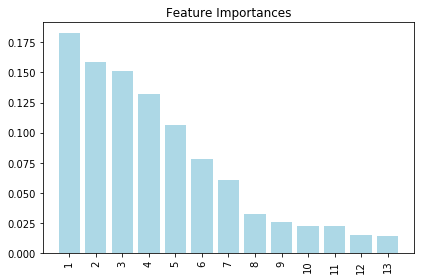

In [36]:
plt.title('Feature Importances')
plt.bar(range(X_train.shape[1]), importances[indices],
       color = 'lightblue', align='center')
plt.xticks(range(X_train.shape[1]),feat_labels, rotation=90)
plt.xlim([-1,X_train.shape[1]])
plt.tight_layout()
plt.show()

In [49]:
import numpy as np
cov_mat = np.cov(X_train_std.T)
eigen_vals, eigen_vecs = np.linalg.eig(cov_mat)
print('\nEigenvalues \n%s'%eigen_vals)


Eigenvalues 
[4.8923083  2.46635032 1.42809973 1.01233462 0.84906459 0.60181514
 0.52251546 0.08414846 0.33051429 0.29595018 0.16831254 0.21432212
 0.2399553 ]


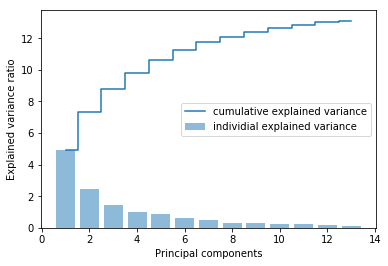

In [47]:
tot = sum(eigen_vals)
var_exp = [(i%tot) for i in sorted(eigen_vals,reverse = True)]
cum_var_exp = np.cumsum(var_exp)

import matplotlib.pyplot as plt
plt.bar(range(1,14), var_exp, alpha=0.5,align='center',label = 'individial explained variance')
plt.step(range(1,14),cum_var_exp, where='mid',label='cumulative explained variance')
plt.ylabel('Explained variance ratio')
plt.xlabel('Principal components')
plt.legend(loc='best')
plt.show()

In [51]:
eigen_pairs = [(np.abs(eigen_vals[i]), eigen_vecs[:,i]) for i in range(len(eigen_vals))]
eigen_pairs.sort(reverse=True)

In [59]:
w = np.hstack((eigen_pairs[0][1][:,np.newaxis],eigen_pairs[1][1][:,np.newaxis])) # column wise
print('Matrix W:\n',w)

Matrix W:
 [[ 0.14669811  0.50417079]
 [-0.24224554  0.24216889]
 [-0.02993442  0.28698484]
 [-0.25519002 -0.06468718]
 [ 0.12079772  0.22995385]
 [ 0.38934455  0.09363991]
 [ 0.42326486  0.01088622]
 [-0.30634956  0.01870216]
 [ 0.30572219  0.03040352]
 [-0.09869191  0.54527081]
 [ 0.30032535 -0.27924322]
 [ 0.36821154 -0.174365  ]
 [ 0.29259713  0.36315461]]


In [60]:
X_train_pca = X_train_std.dot(w)

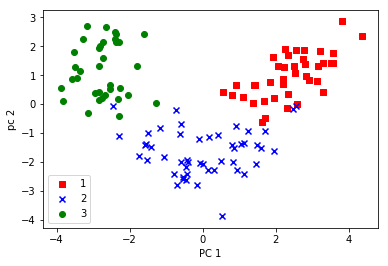

In [63]:
colors = ['r','b','g']
markers = ['s','x','o']
for l,c,m in zip(np.uninpque(y_train),colors,markers):
    plt.scatter(X_train_pca[y_train==l,0],X_train_pca[y_train==l,1],c = c, label=l, marker=m)
plt.xlabel('PC 1')
plt.ylabel('pc 2')
plt.legend(loc='lower left')
plt.show()

In [124]:
from matplotlib.colors import ListedColormap
def plot_decision_regions(X,y,classifier, resolution=0.02):
    #建立符号产生器和颜色地图
    markers = ('s','x','o','^','v')
    colors = ('red','blue','lightgreen','gray','cyan')
    cmap = ListedColormap(colors[:len(np.unique(y))])
    
    # 画出决策表面
    x1_min, x1_max = X[:, 0].min() -1, X[:, 0].max() +1
    x2_min, x2_max = X[:, 1].min() -1, X[:, 1].max() +1
    xx1, xx2 = np.meshgrid(np.arange(x1_min,x1_max,resolution),np.arange(x2_min,x2_max, resolution))
   # print(np.array([xx1.ravel(),xx2.ravel()]).T)
    z = classifier.predict(np.array([xx1.ravel(),xx2.ravel()]).T)
   # print(z.shape)
    z = z.reshape(xx1.shape)
   # print(xx1.shape)
   # print(xx2)
    plt.contourf(xx1,xx2,z,alpha=0.4,cmap=cmap)
    plt.xlim(xx1.min(),xx1.max())
    plt.ylim(xx2.min(),xx2.max())
    
    # plot class samples
    for idx,cl in enumerate(np.unique(y)):
        plt.scatter(x=X[y==cl,0],y=X[y==cl,1],alpha=0.8,c=cmap(idx),marker=markers[idx],label=cl)

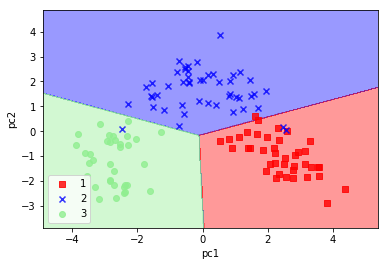

In [81]:
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
lr = LogisticRegression()
X_train_pca = pca.fit_transform(X_train_std)
X_test_pca = pca.transform(X_test_std)
lr.fit(X_train_pca, y_train)
plot_decision_regions(X_train_pca,y_train,classifier=lr)
plt.xlabel('pc1')
plt.ylabel('pc2')
plt.legend(loc='lower left')
plt.show()

In [71]:
a = np.array([[[ 0,  2,  4],
                [ 1,  3,  5]],
               [[ 6,  8, 10],
                [ 7,  9, 11]]])

In [72]:
a.shape

(2, 2, 3)

In [86]:
# LDA 实现
np.set_printoptions(precision=4) #array输出保留四位有效数字
mean_vecs = []
for label in range(1,4):
    mean_vecs.append(np.mean(X_train_std[y_train==label],axis=0))
    print('MV %s: %s\n'%(label,mean_vec[label-1]))

MV 1: [ 0.9259 -0.3091  0.2592 -0.7989  0.3039  0.9608  1.0515 -0.6306  0.5354
  0.2209  0.4855  0.798   1.2017]

MV 2: [-0.8727 -0.3854 -0.4437  0.2481 -0.2409 -0.1059  0.0187 -0.0164  0.1095
 -0.8796  0.4392  0.2776 -0.7016]

MV 3: [ 0.1637  0.8929  0.3249  0.5658 -0.01   -0.9499 -1.228   0.7436 -0.7652
  0.979  -1.1698 -1.3007 -0.3912]



In [112]:
#效果很差，必须要进行类间误差的标准化
d = 13 # number of features
S_W = np.zeros((d,d))
for label,mv in zip(range(1,4),mean_vecs):
    class_scatter = np.zeros((d,d))
    for row in X[y==label]:
        row,mv = row.reshape(d,1),mv.reshape(d,1)
        class_scatter += (row-mv).dot((row-mv).T)
    S_W += class_scatter
print('Within-class scatter matrix: %sx%s'%(S_W.shape[0],S_W.shape[1]))
print('Class label distribution: %s'%np.bincount(y_train)[1:])

Within-class scatter matrix: 13x13
Class label distribution: [40 49 35]


In [116]:
d = 13 # number of features
S_W = np.zeros((d,d))
for label,mv in zip(range(1,4),mean_vecs):
    '''class_scatter = np.zeros((d,d))
    for row in X[y==label]:
        row,mv = row.reshape(d,1),mv.reshape(d,1)
        class_scatter += (row-mv).dot((row-mv).T)'''
    #类内方差取平均
    class_scatter = np.cov(X_train_std[y_train==label].T) # convariance matrix
    S_W += class_scatter
print('Within-class scatter matrix: %sx%s'%(S_W.shape[0],S_W.shape[1]))
print('Class label distribution: %s'%np.bincount(y_train)[1:])

Within-class scatter matrix: 13x13
Class label distribution: [40 49 35]


In [108]:
# 计算类间方差
mean_overall = np.mean(X_train_std,axis=0)
S_B = np.zeros((d,d))
for i, mean_vec in enumerate(mean_vecs):
    n = X[y==i+1,:].shape[0]
    mean_vec = mean_vec.reshape(d,1)
    mean_overall = mean_overall.reshape(d,1)
    S_B = n*(mean_vec-mean_overall).dot((mean_vec-mean_overall).T)
print('Between-class scatter matrix: %sx%s'%(S_B.shape[0],S_B.shape[1]))

Between-class scatter matrix: 13x13


In [117]:
# 求eigenvalue 和eigenvector
eigen_vals, eigen_vecs = np.linalg.eig(np.linalg.inv(S_W).dot(S_B))

eigen_pairs = [(np.abs(eigen_vals[i]),eigen_vecs[i]) for i in range(len(eigen_vals))]
eigen_pairs = sorted(eigen_pairs,key = lambda k:k[0],reverse=True)
for eigen_val in eigen_pairs:
    print(eigen_val[0])

370.01109651149613
3.373556254443343e-14
2.6301682755901093e-14
2.520474936383214e-14
2.520474936383214e-14
2.025859088684603e-14
6.593333179816377e-15
6.593333179816377e-15
4.652201432022415e-15
2.5423924149356043e-15
2.5423924149356043e-15
4.629241573128696e-18
0.0


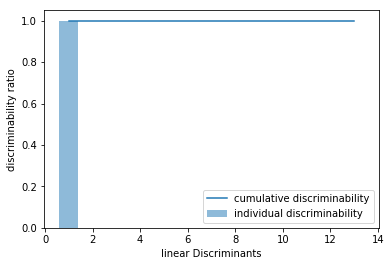

In [118]:
tot = sum(eigen_vals.real)
discr = [(i/tot) for i in sorted(eigen_vals.real,reverse=True)]
cum_discr = np.cumsum(discr)
plt.bar(range(1,14),discr,alpha=0.5, align='center', label='individual discriminability')
plt.step(range(1,14),cum_discr, where='mid',label='cumulative discriminability')
plt.ylabel('discriminability ratio')
plt.xlabel('linear Discriminants')
plt.legend(loc='best')
plt.show()

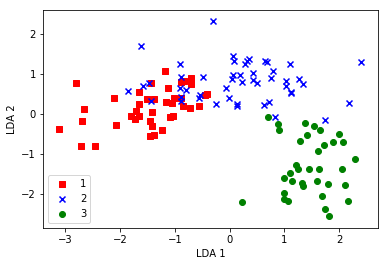

In [119]:
w = np.hstack((eigen_pairs[0][1][:,np.newaxis].real,eigen_pairs[1][1][:,np.newaxis].real))
X_train_lda = X_train_std.dot(w)
colors = ['r','b','g']
markers = ['s','x','o']
for l,c,m in zip(np.unique(y_train),colors,markers):
    plt.scatter(X_train_lda[y_train==l,0],X_train_lda[y_train==l,1],c = c, label=l, marker=m)
plt.xlabel('LDA 1')
plt.ylabel('LDA 2')
plt.legend(loc='lower left')
plt.show()

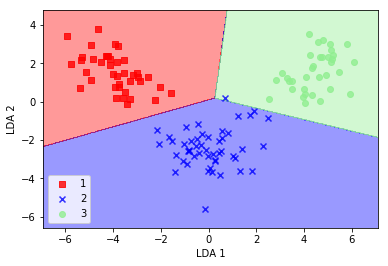

In [127]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
lda = LDA(n_components=2)
X_train_lda = lda.fit_transform(X_train_std,y_train)
lr = LogisticRegression()
lr = lr.fit(X_train_lda,y_train)
plot_decision_regions(X_train_lda,y_train,classifier=lr)
plt.xlabel('LDA 1')
plt.ylabel('LDA 2')
plt.legend(loc='lower left')
plt.show()

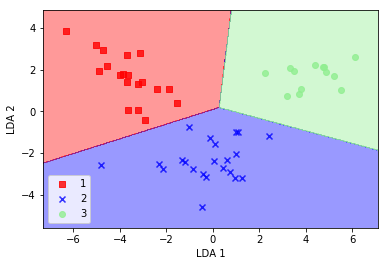

In [128]:
X_test_lda = lda.transform(X_test_std)
plot_decision_regions(X_test_lda, y_test, classifier=lr)
plt.xlabel('LDA 1')
plt.ylabel('LDA 2')
plt.legend(loc='lower left')
plt.show()

In [13]:
# PCA with kernel
from scipy.spatial.distance import pdist, squareform
from scipy import exp
from scipy.linalg import eigh
import numpy as np

def rbf_kernel_pca(X,gamma,n_components):
    """
    RBF kernel PCA implementation.
    Parameters
    ------------
    X: {NumPy ndarray}, shape = [n_samples, n_features]
    gamma: float
    Tuning parameter of the RBF kernel
    n_components: int
    Number of principal components to return
    Returns
    ------------
    X_pc: {NumPy ndarray}, shape = [n_samples, k_features]
    Projected dataset
    """
    # Calculate pairwise squared Euclidean distances
    # in the MxN dimensional dataset.
    sq_dists = pdist(X, 'sqeuclidean') #对x中的任意两组向量之间计算距离，所以总共有M(M-1)/2
    print(sq_dists.shape)
    
    # Convert pairwise distance into a square matrix
    mat_sq_dists = squareform(sq_dists) #构建正交的对称矩阵，对角线为0,这里sq_dist是M(M-1)/2,所以返回的是M×M的矩阵
    print(mat_sq_dists.shape)
    
    # compute the symetric kernel matrix
    K = exp(-gamma*mat_sq_dists) #这边采用的是RBF方程，所以是距离的平方/方差，也就是说gamma是方差的倒数
    print(K.shape)
    
    # Center the kernel matrix
    N = K.shape[0]
    one_n = np.ones((N,N))/N
    K = K - one_n.dot(K)-K.dot(one_n) + one_n.dot(K).dot(one_n) #为什么不直接在X上面做中心化和归一化？
    
    # Obtaining eigenpairs from the centered kernel matrix
    # numpy.eigh returns them in sorted order
    eigvals, eigvecs = eigh(K)
    
    # Collect the top k eigenvectors (projected samples)
    X_pc = np.column_stack((eigvecs[:, -i] for i in range(1, n_components + 1)))
    return X_pc
    
    
    

In [14]:
from sklearn.datasets import make_moons
X, y = make_moons(n_samples=100, random_state=123)
plt.scatter(X[y==0, 0], X[y==0, 1],color='red', marker='^', alpha=0.5)
plt.scatter(X[y==1, 0], X[y==1, 1],color='blue', marker='o', alpha=0.5)
plt.show()


NameError: name 'plt' is not defined

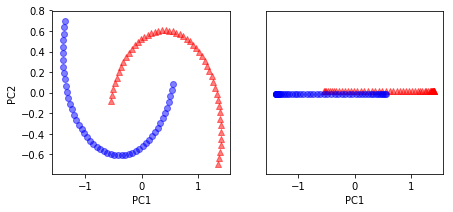

In [138]:
from sklearn.decomposition import PCA
scikit_pca = PCA(n_components=2)
X_spca = scikit_pca.fit_transform(X)
fig, ax = plt.subplots(nrows=1,ncols=2, figsize=(7,3))
ax[0].scatter(X_spca[y==0, 0], X_spca[y==0, 1],color='red', marker='^', alpha=0.5)
ax[0].scatter(X_spca[y==1, 0], X_spca[y==1, 1],color='blue', marker='o', alpha=0.5)
ax[1].scatter(X_spca[y==0, 0], np.zeros((50,1))+0.02,color='red', marker='^', alpha=0.5)
ax[1].scatter(X_spca[y==1, 0], np.zeros((50,1))-0.02,color='blue', marker='o', alpha=0.5)
ax[0].set_xlabel('PC1')
ax[0].set_ylabel('PC2')
ax[1].set_ylim([-1, 1])
ax[1].set_yticks([])
ax[1].set_xlabel('PC1')
plt.show()

(4950,)
(100, 100)
(100, 100)


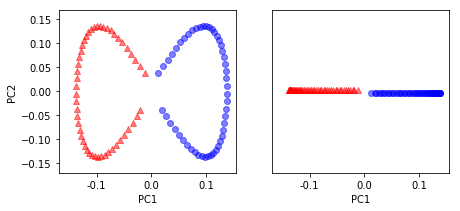

In [139]:
from matplotlib.ticker import FormatStrFormatter
X_kpca = rbf_kernel_pca(X, gamma=15, n_components=2)
fig, ax = plt.subplots(nrows=1,ncols=2, figsize=(7,3))
ax[0].scatter(X_kpca[y==0, 0], X_kpca[y==0, 1],color='red', marker='^', alpha=0.5)
ax[0].scatter(X_kpca[y==1, 0], X_kpca[y==1, 1],color='blue', marker='o', alpha=0.5)
ax[1].scatter(X_kpca[y==0, 0], np.zeros((50,1))+0.02,color='red', marker='^', alpha=0.5)
ax[1].scatter(X_kpca[y==1, 0], np.zeros((50,1))-0.02,color='blue', marker='o', alpha=0.5)
ax[0].set_xlabel('PC1')
ax[0].set_ylabel('PC2')
ax[1].set_ylim([-1, 1])
ax[1].set_yticks([])
ax[1].set_xlabel('PC1')
ax[0].xaxis.set_major_formatter(FormatStrFormatter('%0.1f'))
ax[1].xaxis.set_major_formatter(FormatStrFormatter('%0.1f'))
plt.show()

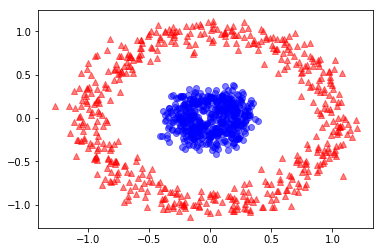

In [140]:
from sklearn.datasets import make_circles
X, y = make_circles(n_samples=1000,random_state=123, noise=0.1, factor=0.2)
plt.scatter(X[y==0, 0], X[y==0, 1],color='red', marker='^', alpha=0.5)
plt.scatter(X[y==1, 0], X[y==1, 1],color='blue', marker='o', alpha=0.5)
plt.show()

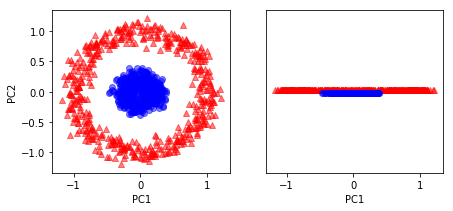

In [141]:
scikit_pca = PCA(n_components=2)
X_spca = scikit_pca.fit_transform(X)
fig, ax = plt.subplots(nrows=1,ncols=2, figsize=(7,3))
ax[0].scatter(X_spca[y==0, 0], X_spca[y==0, 1],color='red', marker='^', alpha=0.5)
ax[0].scatter(X_spca[y==1, 0], X_spca[y==1, 1],color='blue', marker='o', alpha=0.5)
ax[1].scatter(X_spca[y==0, 0], np.zeros((500,1))+0.02,color='red', marker='^', alpha=0.5)
ax[1].scatter(X_spca[y==1, 0], np.zeros((500,1))-0.02,color='blue', marker='o', alpha=0.5)
ax[0].set_xlabel('PC1')
ax[0].set_ylabel('PC2')
ax[1].set_ylim([-1, 1])
ax[1].set_yticks([])
ax[1].set_xlabel('PC1')
plt.show()

(499500,)
(1000, 1000)
(1000, 1000)


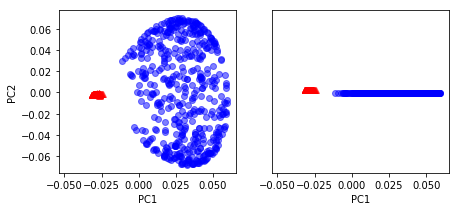

In [142]:
X_kpca = rbf_kernel_pca(X, gamma=15, n_components=2)
fig, ax = plt.subplots(nrows=1,ncols=2, figsize=(7,3))
ax[0].scatter(X_kpca[y==0, 0], X_kpca[y==0, 1],color='red', marker='^', alpha=0.5)
ax[0].scatter(X_kpca[y==1, 0], X_kpca[y==1, 1],color='blue', marker='o', alpha=0.5)
ax[1].scatter(X_kpca[y==0, 0], np.zeros((500,1))+0.02,color='red', marker='^', alpha=0.5)
ax[1].scatter(X_kpca[y==1, 0], np.zeros((500,1))-0.02,color='blue', marker='o', alpha=0.5)
ax[0].set_xlabel('PC1')
ax[0].set_ylabel('PC2')
ax[1].set_ylim([-1, 1])
ax[1].set_yticks([])
ax[1].set_xlabel('PC1')
plt.show()

In [143]:
X.shape

(1000, 2)

In [19]:
from scipy.spatial.distance import pdist, squareform
from scipy import exp
from scipy.linalg import eigh
import numpy as np
def rbf_kernel_pca(X, gamma, n_components):
    """
    RBF kernel PCA implementation.
    Parameters
    ------------
    X: {NumPy ndarray}, shape = [n_samples, n_features]
    gamma: float
    Tuning parameter of the RBF kernel
    n_components: int
    Number of principal components to return
    Returns
    ------------
    X_pc: {NumPy ndarray}, shape = [n_samples, k_features]
    Projected dataset
    lambdas: list
    Eigenvalues
    """
    # Calculate pairwise squared Euclidean distances
    # in the MxN dimensional dataset.
    sq_dists = pdist(X, 'sqeuclidean')
    # Convert pairwise distances into a square matrix.
    mat_sq_dists = squareform(sq_dists)
    
    # Compute the symmetric kernel matrix.
    K = exp(-gamma * mat_sq_dists)

    # Center the kernel matrix.
    N = K.shape[0]
    one_n = np.ones((N,N)) / N
    K = K - one_n.dot(K) - K.dot(one_n) + one_n.dot(K).dot(one_n)
    
    # Obtaining eigenpairs from the centered kernel matrix
    # numpy.eigh returns them in sorted order
    eigvals, eigvecs = eigh(K)
    
    # Collect the top k eigenvectors (projected samples)
    alphas = np.column_stack((eigvecs[:,-i] for i in range(1,n_components+1)))
    print(alphas)
    print(alphas.shape)
    
    # Collect the corresponding eigenvalues
    lambdas = [eigvals[-i] for i in range(1,n_components+1)]
    return alphas, lambdas


In [21]:
X, y = make_moons(n_samples=100, random_state=123)
alphas, lambdas =rbf_kernel_pca(X, gamma=15, n_components=1)
x_new = X[25]
x_new
lambdas

[[-0.07455287]
 [ 0.13184362]
 [ 0.12522054]
 [-0.13494176]
 [ 0.10516006]
 [-0.0121587 ]
 [-0.05279084]
 [ 0.0121587 ]
 [ 0.12834211]
 [-0.04514474]
 [-0.13653254]
 [ 0.11490455]
 [ 0.13699382]
 [ 0.08776328]
 [-0.13715755]
 [-0.07190802]
 [ 0.13620387]
 [-0.09757123]
 [ 0.06026745]
 [ 0.13731155]
 [-0.11322075]
 [ 0.09757123]
 [-0.12935107]
 [-0.13320861]
 [-0.12834211]
 [ 0.07877284]
 [ 0.11322075]
 [-0.08130447]
 [ 0.0373761 ]
 [-0.07877284]
 [-0.13387369]
 [ 0.0853533 ]
 [-0.12165175]
 [ 0.12935107]
 [ 0.11764729]
 [ 0.10316483]
 [ 0.0498413 ]
 [ 0.03441585]
 [ 0.09971242]
 [-0.09971242]
 [-0.13184362]
 [ 0.0916269 ]
 [-0.10316483]
 [ 0.08130447]
 [-0.02128409]
 [ 0.13715755]
 [-0.09390656]
 [ 0.13320861]
 [-0.11023007]
 [ 0.04514474]
 [-0.11916726]
 [-0.13699382]
 [ 0.02128409]
 [-0.0498413 ]
 [-0.06026745]
 [ 0.02692825]
 [-0.13100714]
 [-0.05741388]
 [ 0.13543746]
 [-0.0647807 ]
 [-0.11490455]
 [ 0.05741388]
 [-0.12640181]
 [-0.10516006]
 [-0.13543746]
 [-0.08776328]
 [ 0.07455

[7.062724756679956]

In [146]:
x_proj = alphas[25] # original projection
x_proj


array([0.0788])

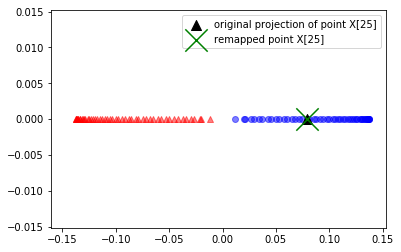

In [147]:
def project_x(x_new, X, gamma, alphas, lambdas):
    pair_dist = np.array([np.sum((x_new-row)**2) for row in X])
    k = np.exp(-gamma * pair_dist)
    return k.dot(alphas / lambdas) # 通过eigenvalue正则eigenvector。

x_reproj = project_x(x_new, X,gamma=15, alphas=alphas, lambdas=lambdas)
plt.scatter(alphas[y==0, 0], np.zeros((50)),color='red', marker='^',alpha=0.5)
plt.scatter(alphas[y==1, 0], np.zeros((50)),color='blue', marker='o', alpha=0.5)
plt.scatter(x_proj, 0, color='black',label='original projection of point X[25]',marker='^', s=100)
plt.scatter(x_reproj, 0, color='green',label='remapped point X[25]',marker='x', s=500)
plt.legend(scatterpoints=1)
plt.show()